In [1]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2 as cv
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob

from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
data_folder = '/content/gdrive/MyDrive/Projects/Fire Detection/dataset/fire_dataset'

Mounted at /content/gdrive


In [3]:
categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [4]:
image_count = {}
train_data = []

for i, category in tqdm(enumerate(categories)):
  class_folder = os.path.join(data_folder, category)
  label = category
  image_count[category] = []

  for path in os.listdir(os.path.join(class_folder)):
    image_count[category].append(category)
    train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:03,  1.98s/it]


In [5]:
# show image count
for key, value in image_count.items():
  print('{0} -> {1}'.format(key, len(value)))

fire_images -> 755
non_fire_images -> 244


In [6]:
# create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

(999, 3)

,file,id,label
0,fire_images/fire.10.png,0,fire_images
1,fire_images/fire.1.png,0,fire_images
2,fire_images/fire.109.png,0,fire_images
3,fire_images/fire.112.png,0,fire_images
4,fire_images/fire.102.png,0,fire_images


### IMAGE PREPROCESSING

In [7]:
# masking function
def create_mask_for_plant(image):
  image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
  lower_hsv = np.array([0,0,250])
  upper_hsv = np.array([250,255,255])
  mask = cv.inRange(image_hsv, lower_hsv, upper_hsv)
  kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11,11))
  mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
  return mask

# image segmentation function
def segment_image(image):
  mask = create_mask_for_plant(image)
  output = cv.bitwise_and(image, image, mask = mask)
  return output/255

# sharpen the image
def sharpen_image(image):
  image_blurred = cv.GaussianBlur(image, (0, 0), 3)
  image_sharp = cv.addWeighted(image, 1.5, image_blurred, -0.5, 0)
  return image_sharp

# function to get an image
def read_img(filepath, size):
  img = image.load_img(os.path.join(data_folder, filepath), target_size = size)
  # convert image to array
  img = image.img_to_array(img)
  return img

### SAMPLE IMAGES

Text(0.5, 0.98, 'SAMPLE IMAGES')

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

[]

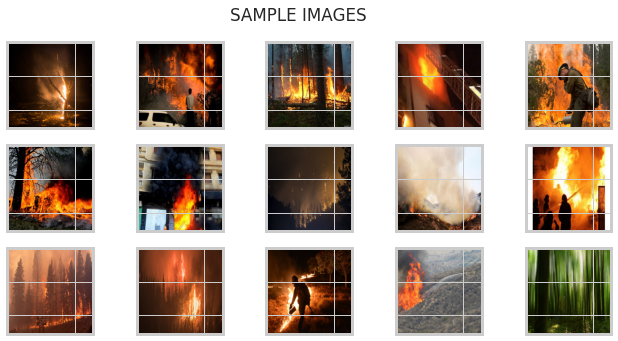

In [8]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize = (10, 5))
plt.suptitle('SAMPLE IMAGES')
for i in range(0, nb_rows):
  for j in range(0, nb_cols):
    axs[i, j].xaxis.set_ticklabels([])
    axs[i, j].yaxis.set_ticklabels([])
    axs[i, j].imshow((read_img(df['file'][np.random.randint(1000)], (255,255)))/255.)
plt.show()

### SAMPLE PROCESSED IMAGE

Text(0.5, 0.8, 'SAMPLE PROCESSED IMAGE')

Text(0.5, 1.0, 'ORIGINAL')

Text(0.5, 1.0, 'MASKED')

Text(0.5, 1.0, 'SEGMENTED')

Text(0.5, 1.0, 'SHARPENED')

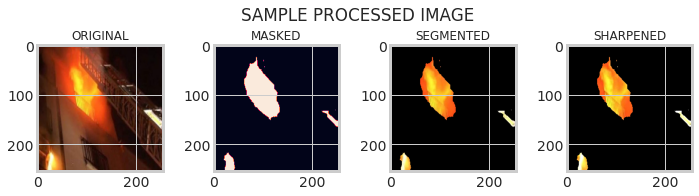

In [9]:
# get an image
img = read_img(df['file'][102], (255, 255))

# mask
image_mask = create_mask_for_plant(img)

# segmentation
image_segmented = segment_image(img)

# sharpen the image
image_sharpen = sharpen_image(image_segmented)

fig, ax = plt.subplots(1, 4, figsize=(10, 5));
plt.suptitle('SAMPLE PROCESSED IMAGE', x = 0.5, y = 0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize = 12)
ax[1].set_title('MASKED', fontsize = 12)
ax[2].set_title('SEGMENTED', fontsize = 12)
ax[3].set_title('SHARPENED', fontsize = 12)

ax[0].imshow(img / 255)
ax[1].imshow(image_mask)
ax[2].imshow(image_segmented)
ax[3].imshow(image_sharpen)

### XCEPTION BOTTLENECK FEATURE EXTRACTION

In [10]:
INPUT_SIZE = 255

# preprocess the input
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, df.shape[1]), dtype = 'float')
for i, file in tqdm(enumerate(df['file'])):
  # read image
  img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
  # masking and segmentation
  image_segmented = segment_image(img)
  # sharpen
  image_sharpen = sharpen_image(image_segmented)
  x = xception.preprocess_input(np.expand_dims(image_sharpen.copy(), axis = 0))
  X_train[i] = x

999it [01:52,  8.92it/s]


In [11]:
print('Train Image Shape:', X_train.shape)
print('Train Image Size:', X_train.size)

Train Image Shape: (999, 255, 255, 3)
Train Image Size: 194879925


### SPLITTING THE DATA

In [12]:
y = df['id']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size = 0.2, random_state = 101)

In [13]:
print('FIRE IMAGES ON TRAINING DATA:', y_train[y_train == 0].shape[0])
print('NON-FIRE IMAGES ON TRAINING DATA:', y_train[y_train == 1].shape[0])

FIRE IMAGES ON TRAINING DATA: 610
NON-FIRE IMAGES ON TRAINING DATA: 189


In [14]:
# get the features
xception_bf = xception.Xception(weights = 'imagenet', include_top = False, pooling = 'avg')
bf_train_x = xception_bf.predict(train_x, batch_size = 32, verbose = 1)
bf_train_val = xception_bf.predict(train_val, batch_size = 32, verbose = 1)

7/7 [==============================] - 46s 7s/step


In [15]:
# print shape of feature and size
print('Train Shape:', bf_train_x.shape)
print('Train Size:', bf_train_x.size)

print('Validation Shape:', bf_train_val.shape)
print('Validation Size:', bf_train_val.size)

Train Shape: (799, 2048)
Train Size: 1636352
Validation Shape: (200, 2048)
Validation Size: 409600


### DEEP LEARNING MODEL

In [16]:
# keras Sequential model
model = Sequential()
model.add(Dense(units = 256, activation = 'relu', input_dim = bf_train_x.shape[1]))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541,057
Trainable params: 541,057
Non-trainable params: 0
_________________________________________________________________


In [17]:
# training the model @ 100 epochs
history = model.fit(bf_train_x, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
25/25 [==============================] - 1s 7ms/step - loss: 0.5339 - accuracy: 0.7635
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4632 - accuracy: 0.7635
Epoch 3/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4084 - accuracy: 0.8235
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4007 - accuracy: 0.8098
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3876 - accuracy: 0.8198
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3366 - accuracy: 0.8411
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 0.3133 - accuracy: 0.8661
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.2988 - accuracy: 0.8736
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 0.2759 - accuracy: 0.8698
Epoch 10/100
25/25 [==============================] - 0s 7ms/step - loss: 0.2774 - accuracy: 0.8673
Epoch 11/

### LOSS AND ACCURACY

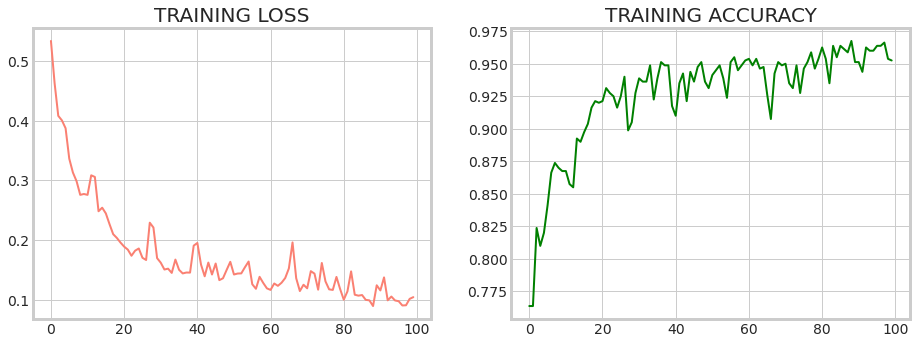

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');

ax[0].plot(history.history['loss'], color = 'salmon', lw = 2);
ax[1].plot(history.history['accuracy'], color = 'green', lw = 2);

In [19]:
predict_x = model.predict(bf_train_val) 
predictions = np.round(predict_x)

### CLASSIFICATION REPORT

In [21]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       145
           1       0.82      0.82      0.82        55

    accuracy                           0.90       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.90      0.90      0.90       200



### CONFUSION MATRIX

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'CONFUSION MATRIX')

Text(0.5, 69.93999999999996, 'Y_TRUE')

Text(36.099999999999994, 0.5, 'PREDICTIONS')

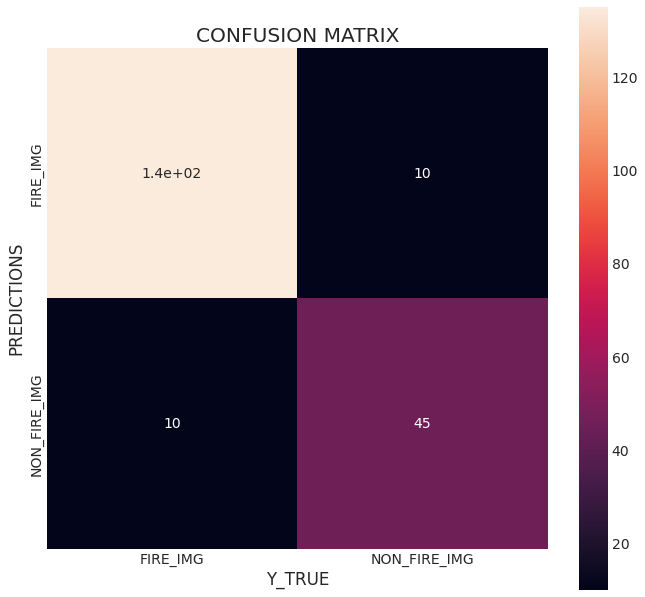

In [22]:
confusion_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize = (10, 10))
sns.heatmap(confusion_mat, square = True, annot = True, yticklabels = ['FIRE_IMG', 'NON_FIRE_IMG'], xticklabels = ['FIRE_IMG', 'NON_FIRE_IMG'])
plt.title('CONFUSION MATRIX')
plt.xlabel('Y_TRUE')
plt.ylabel('PREDICTIONS')